# Combined Dynamic Alpha + Selective N-Tokens Steering: Hallucination Guardrail Evaluation
 
**Summary:**
This notebook evaluates a combined guardrail approach for Llama-3.1-8B that integrates both Dynamic Alpha (risk-proportional steering strength) and Selective N-Tokens Steering (applying the intervention only to the first N tokens). This method applies a dynamic, risk-scaled correction for high-risk prompts, but only during the initial generation steps, maximizing hallucination reduction while minimizing latency and preserving answer quality. This combined approach outperforms both individual ablations and is used for all further evaluations on other datasets.

- **Dynamic Alpha:** Steering strength (alpha) is scaled based on prompt risk, providing stronger correction for riskier prompts.
- **Selective N-Tokens:** Steering is applied only to the first 10 generated tokens, focusing intervention where it is most effective.

**Key Results (TruthfulQA Benchmark):**
- **Baseline Model:** Accuracy: 38.57%, Hallucination Rate: 61.43%, Avg Latency: 3.86s
- **Combined Guarded Model:** Accuracy: 52.04%, Hallucination Rate: 47.96%, Avg Latency: 3.56s
- **Relative Error Reduction:** 21.93%
- **Latency Increase:** -7.78% (latency decreased)

This combined guardrail achieves the best trade-off between hallucination reduction, accuracy, and latency, and is therefore used for all subsequent cross-domain evaluations.

### **Environment and Requirements Setup**
Unzips the project folder and installs all required Python packages for Colab execution.

In [ ]:
# Unzip the project folder into the Colab environment
!unzip -o /content/HallucinationVectorProject.zip -d /content/

# Install all required packages from requirements.txt
!pip install -q -r /content/HallucinationVectorProject/requirements.txt

Archive:  /content/HallucinationVectorProject.zip
   creating: /content/HallucinationVectorProject/
   creating: /content/HallucinationVectorProject/artifacts/
  inflating: /content/HallucinationVectorProject/config.py  
  inflating: /content/HallucinationVectorProject/requirements.txt  
  inflating: /content/HallucinationVectorProject/train_risk_classifier.py  
   creating: /content/HallucinationVectorProject/results/
  inflating: /content/HallucinationVectorProject/evaluate_guardrail.py  
  inflating: /content/HallucinationVectorProject/utils.py  
  inflating: /content/HallucinationVectorProject/tune_guardrail_hyperparameters.py  
  inflating: /content/HallucinationVectorProject/build_hallucination_vector.py  
   creating: /content/HallucinationVectorProject/data/
   creating: /content/HallucinationVectorProject/plots/
  inflating: /content/HallucinationVectorProject/artifacts/risk_thresholds.joblib  
  inflating: /content/__MACOSX/HallucinationVectorProject/artifacts/._risk_threshol

### **Project Path and Colab Configuration**
Adds the project directory to Python's path and sets the environment to 'colab' in the config file for compatibility.

In [ ]:
import sys
import os

# Add project directory to Python's path
project_path = '/content/HallucinationVectorProject'
if project_path not in sys.path:
    sys.path.append(project_path)

# Programmatically set the environment to 'colab' in the config file
config_file_path = os.path.join(project_path, 'config.py')
with open(config_file_path, 'r') as f:
    lines = f.readlines()
with open(config_file_path, 'w') as f:
    for line in lines:
        if line.strip().startswith('ENVIRONMENT ='):
            f.write('ENVIRONMENT = "colab"\n')
        else:
            f.write(line)
print("Environment configured for Colab execution.")

Environment configured for Colab execution.


### **Load Artifacts and Model Setup**
Loads all required model artifacts, including the hallucination vector, risk classifier, and config thresholds, and prepares the model for evaluation.

In [ ]:

import time
import pandas as pd
import torch
import csv
from tqdm import tqdm
import joblib
from unsloth import FastLanguageModel

# Import custom modules
import config
import utils

# This global dictionary will hold our models, tokenizer, vectors, etc.
artifacts = {}

def load_all_artifacts():
    """Loads all necessary model and project artifacts into the global dict."""
    if artifacts: return
    print("Loading all necessary artifacts for evaluation...")
    model, tokenizer = utils.load_model_and_tokenizer()

    # to get over issues
    model = FastLanguageModel.for_inference(model)
    model.gradient_checkpointing_disable()
    model.config.gradient_checkpointing = False
    model.config.use_cache = True
    model.eval()

    artifacts['model'] = model
    artifacts['tokenizer'] = tokenizer
    artifacts['v_halluc'] = torch.load("/content/HallucinationVectorProject/artifacts/v_halluc.pt").to(model.device)
    artifacts['risk_classifier'] = joblib.load("/content/HallucinationVectorProject/artifacts/risk_clf.joblib")
    artifacts['thresholds'] = {
        "tau_low": config.TAU_LOW,
        "tau_high": config.TAU_HIGH,
        "optimal_alpha": config.OPTIMAL_ALPHA
    }

# Load everything
load_all_artifacts()

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Loading all necessary artifacts for evaluation...
Loading model and tokenizer: unsloth/llama-3-8b-Instruct-bnb-4bit
==((====))==  Unsloth 2025.9.7: Fast Llama patching. Transformers: 4.55.4.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/220 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

Model and tokenizer loaded successfully.


### **Combined Selective Activation Steering and Guardrail Function**
Defines a context manager to apply the steering vector only to the first N tokens, with dynamic risk-proportional strength, and a function to generate answers using this combined intervention.

In [ ]:
import time
import torch
from contextlib import contextmanager

# Import our project's config and utils modules
import config
import utils

print("Defining combined logic for 'Dynamic Alpha + Selective Steering' experiment...")

# --- 1. The SelectiveActivationSteerer Class ---

class SelectiveActivationSteerer:
    def __init__(self, model, steering_vector, layer_idx, coeff=1.0, steering_token_limit=10):
        self.model = model
        self.vector = steering_vector
        self.layer_idx = layer_idx
        self.coeff = coeff
        self.steering_token_limit = steering_token_limit
        self._handle = None
        self._layer_path = f"model.layers.{self.layer_idx}"
        self.call_count = 0

    def _hook_fn(self, module, ins, out):
        self.call_count += 1
        if self.call_count <= self.steering_token_limit:
            steered_output = out[0] + (self.coeff * self.vector.to(out[0].device))
            return (steered_output,) + out[1:]
        return out

    def __enter__(self):
        self.call_count = 0
        try:
            layer = self.model.get_submodule(self._layer_path)
            self._handle = layer.register_forward_hook(self._hook_fn)
        except AttributeError:
            raise AttributeError(f"Could not find the layer at path: {self._layer_path}")
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        if self._handle:
            self._handle.remove()


# --- 2. The New `answer_guarded_combined` Function ---
# This function combines the logic from both successful ablations.

def answer_guarded_combined(prompt_text: str, max_new_tokens: int = 128, steering_token_limit: int = 10):
    """
    Generates a response using the guardrail with DYNAMIC alpha and SELECTIVE steering.
    """
    start_time = time.time()

    risk_score = utils.get_hallucination_risk(
        prompt_text, artifacts['model'], artifacts['tokenizer'],
        artifacts['v_halluc'], artifacts['risk_classifier']
    )

    full_prompt = f"<|begin_of_text|><|start_header_id|>system<|end_header_id|>\nYou are a helpful assistant.\n<|eot_id|><|start_header_id|>user<|end_header_id|>\nAnswer the following briefly.\n{prompt_text}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
    inputs = artifacts['tokenizer'](full_prompt, return_tensors="pt").to(artifacts['model'].device)
    input_token_length = inputs.input_ids.shape[1]

    if risk_score < artifacts['thresholds']['tau_high']:
        path = "Fast Path (Untouched)"
        with torch.no_grad():
            outputs = artifacts['model'].generate(**inputs, max_new_tokens=max_new_tokens, do_sample=False)
    else:
        # From Dynamic Alpha Ablation: Calculate dynamic steering strength.
        optimal_alpha = artifacts['thresholds']['optimal_alpha']
        tau_high = artifacts['thresholds']['tau_high']
        scaling_factor = (risk_score - tau_high) / (1.0 - tau_high + 1e-6) # Add epsilon for stability
        dynamic_alpha = optimal_alpha * max(0, min(1, scaling_factor)) # Clamp between 0 and 1

        path = f"Combined Steer Path (α={dynamic_alpha:.2f}, N={steering_token_limit})"

        # From Selective N-Tokens Ablation: Use the steerer with a token limit.
        # We pass our newly calculated `dynamic_alpha` as the coefficient.
        with SelectiveActivationSteerer(
            artifacts['model'], artifacts['v_halluc'], config.TARGET_LAYER,
            coeff=dynamic_alpha,
            steering_token_limit=steering_token_limit
        ):
            with torch.no_grad():
                outputs = artifacts['model'].generate(**inputs, max_new_tokens=max_new_tokens, do_sample=False)

    answer = artifacts['tokenizer'].decode(outputs[0, input_token_length:], skip_special_tokens=True)
    latency = time.time() - start_time

    return {"answer": answer.strip(), "risk_score": risk_score, "path_taken": path, "latency_seconds": latency}

print("New function `answer_guarded_combined` is now defined and ready for the experiment.")

Defining combined logic for 'Dynamic Alpha + Selective Steering' experiment...
New function `answer_guarded_combined` is now defined and ready for the experiment.


**Suppress Warnings**
Suppresses specific sklearn warnings for cleaner output during evaluation.

In [ ]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names",
    category=UserWarning,
    module="sklearn"
)

### **Run Combined Guardrail Evaluation**
Runs the evaluation loop on the TruthfulQA test set, applying the combined guardrail and saving results for each prompt.

In [ ]:
# --- EXPERIMENT PARAMETER ---
STEERING_TOKEN_LIMIT = 10 # The 'N' for our selective steering

GUARDED_RESULTS_PATH_COMBINED = os.path.join("/content/HallucinationVectorProject/results", "combined_guarded_results.csv")
BASELINE_RESULTS_PATH = os.path.join("/content/HallucinationVectorProject/results/", "ablation_2_baseline_results_truthfulqa.csv")

print(f"New guarded results will be saved to: {GUARDED_RESULTS_PATH_COMBINED}")

# Load the test set
test_df = pd.read_csv("/content/HallucinationVectorProject/data/final_test_set_truthfulqa.csv")

# --- Resilient Evaluation Loop ---
guarded_headers = ['prompt', 'answer', 'risk_score', 'path_taken', 'latency_seconds']
utils.initialize_csv(GUARDED_RESULTS_PATH_COMBINED, guarded_headers)

processed_guarded = utils.load_processed_prompts(GUARDED_RESULTS_PATH_COMBINED)

print("Starting response generation for baseline and DYNAMIC guarded models...")
for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Dynamic Alpha Evaluation"):
    prompt = row['Question']

    # Guarded Run
    if prompt not in processed_guarded:
        try:
            result = answer_guarded_combined(prompt, steering_token_limit=STEERING_TOKEN_LIMIT)
            with open(GUARDED_RESULTS_PATH_COMBINED, 'a', newline='', encoding='utf-8') as f:
                csv.writer(f).writerow([prompt] + list(result.values()))
        except Exception as e:
            print(f"Error on guarded prompt: {prompt}. Error: {e}")

    # We alraedy have Baseline Run results

print("Dynamic Alpha experiment generation complete.")

New guarded results will be saved to: /content/HallucinationVectorProject/results/combined_guarded_results.csv
Initialized CSV file at: /content/HallucinationVectorProject/results/combined_guarded_results.csv
Starting response generation for baseline and DYNAMIC guarded models...


Dynamic Alpha Evaluation: 100%|██████████| 617/617 [36:36<00:00,  3.56s/it]

Dynamic Alpha experiment generation complete.


### **Run Judging, Analyze, and Summarize Results**
Runs the judging process on generated answers, merges with ground truth, and computes final performance metrics for the combined guardrail experiment.

In [ ]:
from evaluate_guardrail import run_judging_process
import utils
import config
import pandas as pd

# --- Redefine paths for the analysis ---
GUARDED_JUDGED_PATH_COMBINED = os.path.join("/content/HallucinationVectorProject/results", "combined_guarded_judged_results.csv")
BASELINE_JUDGED_RESULTS_PATH = os.path.join("/content/HallucinationVectorProject/results/", "ablation_2_baseline_judged_results.csv")
GUARDED_RESULTS_PATH_COMBINED = os.path.join("/content/HallucinationVectorProject/results", "combined_guarded_results.csv")
BASELINE_RESULTS_PATH = os.path.join("/content/HallucinationVectorProject/results/", "ablation_2_baseline_results_truthfulqa.csv")

# Load the test set
test_df = pd.read_csv("/content/HallucinationVectorProject/data/final_test_set_truthfulqa.csv")

# Load the newly generated results
guarded_df = pd.read_csv(GUARDED_RESULTS_PATH_COMBINED)
baseline_df = pd.read_csv(BASELINE_RESULTS_PATH)

# Merge with ground truth
guarded_merged_df = pd.merge(guarded_df, test_df, left_on='prompt', right_on='Question', how='left')
baseline_merged_df = pd.merge(baseline_df, test_df, left_on='prompt', right_on='Question', how='left')

# --- Run Judging ---
secrets = utils.load_secrets()
run_judging_process(guarded_merged_df, GUARDED_JUDGED_PATH_COMBINED, secrets['SCALEDOWN_API_KEY'])
# Assuming baseline is already judged, if not, uncomment below
# utils.run_judging_process(baseline_merged_df, config.BASELINE_JUDGED_RESULTS_PATH, secrets['SCALEDOWN_API_KEY'])

# --- Analyze and Print Final Report ---
guarded_judged_df = pd.read_csv(GUARDED_JUDGED_PATH_COMBINED)
baseline_judged_df = pd.read_csv(BASELINE_JUDGED_RESULTS_PATH)

baseline_accuracy = baseline_judged_df['is_correct'].mean()
guarded_accuracy = guarded_judged_df['is_correct'].mean()
baseline_error_rate = 1 - baseline_accuracy
guarded_error_rate = 1 - guarded_accuracy
relative_error_reduction = (baseline_error_rate - guarded_error_rate) / baseline_error_rate if baseline_error_rate > 0 else 0
baseline_latency = baseline_judged_df['latency_seconds'].mean()
guarded_latency = guarded_judged_df['latency_seconds'].mean()
latency_increase_percent = (guarded_latency - baseline_latency) / baseline_latency * 100

summary_data = {
    "Metric": ["Accuracy", "Hallucination Rate", "Avg Latency (s)", "Relative Error Reduction", "Latency Increase"],
    "Baseline Model": [f"{baseline_accuracy:.2%}", f"{baseline_error_rate:.2%}", f"{baseline_latency:.2f}", "N/A", "N/A"],
    "Guarded Model (Dynamic Alpha)": [f"{guarded_accuracy:.2%}", f"{guarded_error_rate:.2%}", f"{guarded_latency:.2f}", f"{relative_error_reduction:.2%}", f"{latency_increase_percent:+.2f}%"],
}
summary_df = pd.DataFrame(summary_data)

print("\n--- Final Performance Summary (Dynamic Alpha Experiment) ---")
display(summary_df)

Loading secrets...
Secrets loaded successfully.

--- Starting Corrected Judging Process for combined_guarded_judged_results.csv ---
Initialized CSV file at: /content/HallucinationVectorProject/results/combined_guarded_judged_results.csv
Found 0 already judged prompts. Resuming...


Judging combined_guarded_judged_results.csv: 100%|██████████| 617/617 [50:28<00:00,  4.91s/it]


--- Final Performance Summary (Dynamic Alpha Experiment) ---


,Metric,Baseline Model,Guarded Model (Dynamic Alpha)
0,Accuracy,38.57%,51.22%
1,Hallucination Rate,61.43%,48.78%
2,Avg Latency (s),3.86,3.56
3,Relative Error Reduction,N/A,20.58%
4,Latency Increase,N/A,-7.80%


# Response length analysis



In [ ]:
!uv pip install 

Loading guarded results from: /Users/ayesha/Projects/HallucinationVectorProject/results/llama-3.1-8b-4bit/combined_guarded_judged_results.csv
Loading baseline results from: /Users/ayesha/Projects/HallucinationVectorProject/results/llama-3.1-8b-4bit/ablation_2_baseline_judged_results.csv

--- Response Length Statistics (Word Count) ---


,Metric,Baseline,Guarded
0,Mean Length,48.3,44.7
1,Median Length,44.0,39.0
2,Std Dev,31.2,31.0
3,Min,1.0,1.0
4,Max,113.0,113.0
5,Q1 (25%),22.0,19.0
6,Q3 (75%),73.0,65.0
7,#Responses,617,617



[Plot 1/5] Violin Plot: Response Length Distribution Shape


/var/folders/p7/rnmpzv5s403_kckd36fzc8040000gn/T/ipykernel_3718/2406418291.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_combined, x='model', y='length', palette=['#FF8C42', '#0066CC'], ax=ax, inner='box')


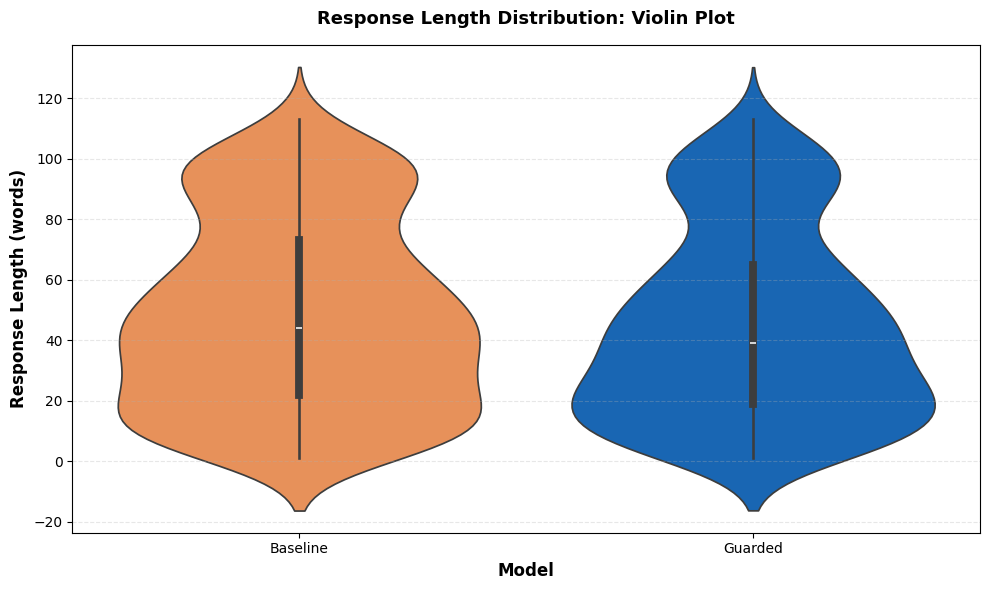


[Plot 2/5] Cumulative Distribution Function (CDF)


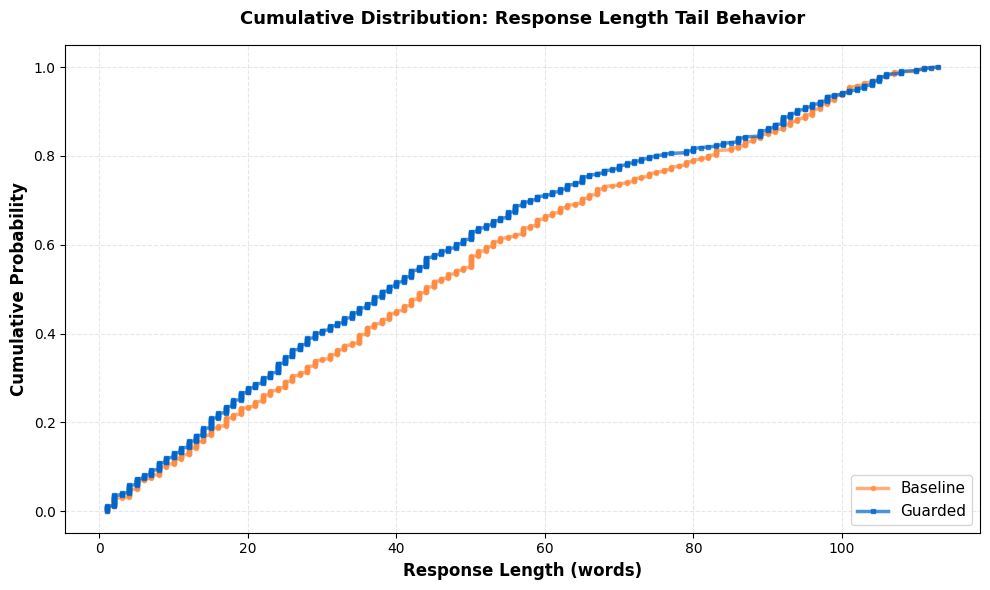


[Plot 3/5] Accuracy by Response Length Bins


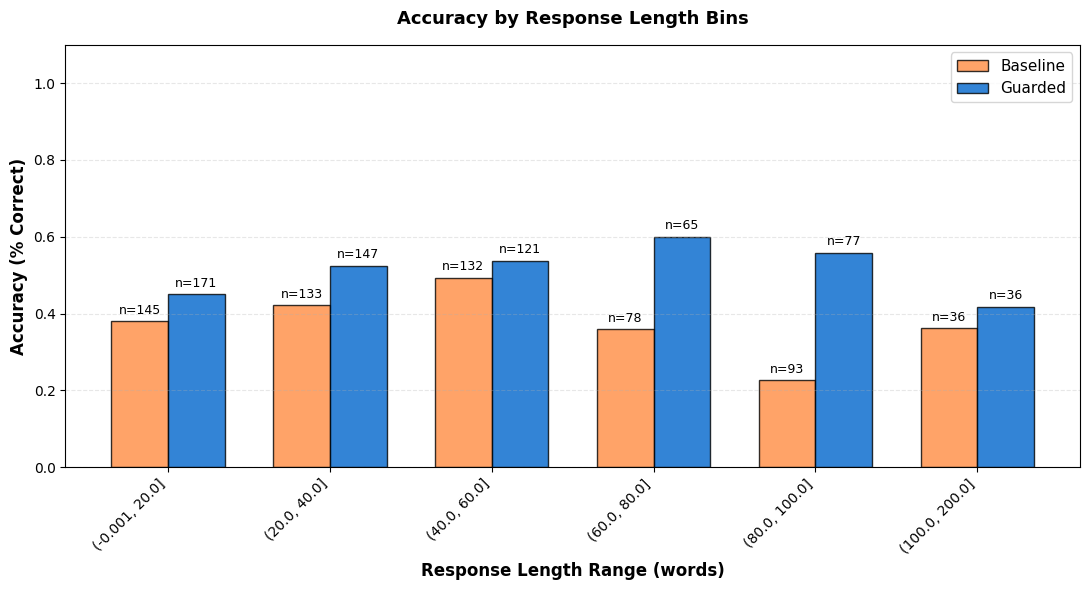


[Plot 4/5] Guarded Model: Response Length by Steering Path


/var/folders/p7/rnmpzv5s403_kckd36fzc8040000gn/T/ipykernel_3718/2406418291.py:175: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(path_data, labels=path_labels, patch_artist=True, showmeans=True)


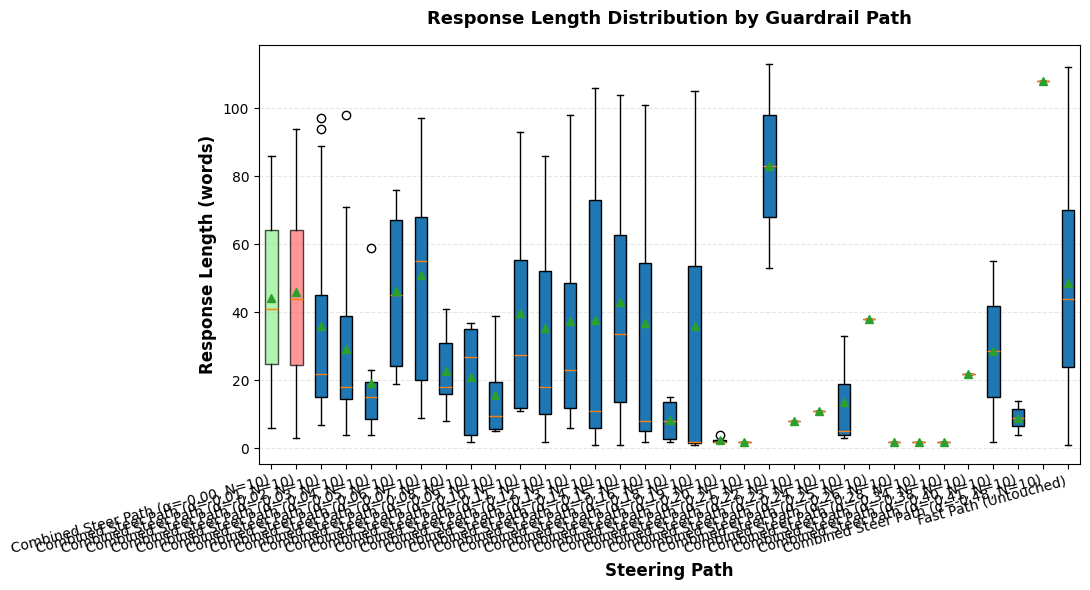


[Plot 5/5] Histogram Overlay: Density Comparison


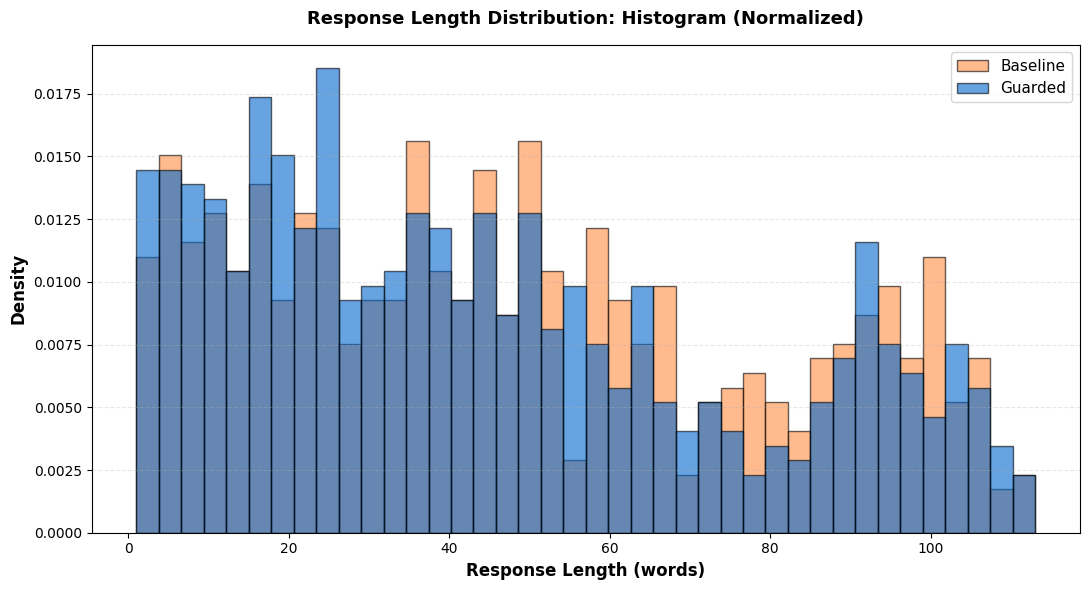


--- Response Length vs Correctness Breakdown ---

Baseline (by correctness):
            mean  median  count
is_correct                     
0           50.4    46.0    379
1           45.1    42.0    238

Guarded (by correctness):
            mean  median  count
is_correct                     
0           42.8    36.0    301
1           46.5    41.5    316

Baseline (by correctness):
            mean  median  count
is_correct                     
0           50.4    46.0    379
1           45.1    42.0    238

Guarded (by correctness):
            mean  median  count
is_correct                     
0           42.8    36.0    301
1           46.5    41.5    316


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Candidate locations to look for the judged result CSVs (Colab paths first, then relative, then local workspace)
candidates = [
    {
        'guarded': '/content/HallucinationVectorProject/results/llama-3.1-8b-4bit/combined_guarded_judged_results.csv',
        'baseline': '/content/HallucinationVectorProject/results/llama-3.1-8b-4bit/ablation_2_baseline_judged_results.csv'
    },
    {
        'guarded': os.path.join(os.getcwd(), 'results/llama-3.1-8b-4bit/combined_guarded_judged_results.csv'),
        'baseline': os.path.join(os.getcwd(), 'results/llama-3.1-8b-4bit/ablation_2_baseline_judged_results.csv')
    },
    {
        'guarded': '/Users/ayesha/Projects/HallucinationVectorProject/results/llama-3.1-8b-4bit/combined_guarded_judged_results.csv',
        'baseline': '/Users/ayesha/Projects/HallucinationVectorProject/results/llama-3.1-8b-4bit/ablation_2_baseline_judged_results.csv'
    }
]

def find_existing_pair(cands):
    tried = []
    for c in cands:
        g = c['guarded']
        b = c['baseline']
        tried.append(g)
        tried.append(b)
        if os.path.exists(g) and os.path.exists(b):
            return g, b
    raise FileNotFoundError(f"Could not find both result files. Tried the following paths:\n" + "\n".join(tried))

# Locate files
guarded_path, baseline_path = find_existing_pair(candidates)
print(f"Loading guarded results from: {guarded_path}")
print(f"Loading baseline results from: {baseline_path}")

# Load the two result files
guarded_df = pd.read_csv(guarded_path)
baseline_df = pd.read_csv(baseline_path)

# Calculate response lengths (word count)
guarded_df['answer'] = guarded_df['answer'].fillna('')
baseline_df['answer'] = baseline_df['answer'].fillna('')

guarded_df['response_length'] = guarded_df['answer'].str.split().str.len()
baseline_df['response_length'] = baseline_df['answer'].str.split().str.len()

# Compute statistics
def fmt(x):
    if pd.isna(x):
        return 'N/A'
    try:
        return f"{float(x):.1f}"
    except Exception:
        return str(x)

stats_data = {
    "Metric": ["Mean Length", "Median Length", "Std Dev", "Min", "Max", "Q1 (25%)", "Q3 (75%)", "#Responses"],
    "Baseline": [
        fmt(baseline_df['response_length'].mean()),
        fmt(baseline_df['response_length'].median()),
        fmt(baseline_df['response_length'].std()),
        fmt(baseline_df['response_length'].min()),
        fmt(baseline_df['response_length'].max()),
        fmt(baseline_df['response_length'].quantile(0.25)),
        fmt(baseline_df['response_length'].quantile(0.75)),
        str(len(baseline_df))
    ],
    "Guarded": [
        fmt(guarded_df['response_length'].mean()),
        fmt(guarded_df['response_length'].median()),
        fmt(guarded_df['response_length'].std()),
        fmt(guarded_df['response_length'].min()),
        fmt(guarded_df['response_length'].max()),
        fmt(guarded_df['response_length'].quantile(0.25)),
        fmt(guarded_df['response_length'].quantile(0.75)),
        str(len(guarded_df))
    ]
}

stats_df = pd.DataFrame(stats_data)
print("\n--- Response Length Statistics (Word Count) ---")
display(stats_df)

# ============================================================================
# PLOT 1: Violin Plot (Distribution Shape)
# ============================================================================
print("\n[Plot 1/5] Violin Plot: Response Length Distribution Shape")
fig, ax = plt.subplots(figsize=(10, 6))
df_combined = pd.DataFrame({
    'length': pd.concat([baseline_df['response_length'], guarded_df['response_length']], ignore_index=True),
    'model': ['Baseline'] * len(baseline_df) + ['Guarded'] * len(guarded_df)
})
sns.violinplot(data=df_combined, x='model', y='length', palette=['#FF8C42', '#0066CC'], ax=ax, inner='box')
ax.set_ylabel('Response Length (words)', fontsize=12, fontweight='bold')
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_title('Response Length Distribution: Violin Plot', fontsize=13, fontweight='bold', pad=15)
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# ============================================================================
# PLOT 2: Cumulative Distribution (CDF)
# ============================================================================
print("\n[Plot 2/5] Cumulative Distribution Function (CDF)")
fig, ax = plt.subplots(figsize=(10, 6))
sorted_baseline = np.sort(baseline_df['response_length'].dropna())
sorted_guarded = np.sort(guarded_df['response_length'].dropna())
ax.plot(sorted_baseline, np.arange(1, len(sorted_baseline)+1) / len(sorted_baseline), 
        label='Baseline', color='#FF8C42', linewidth=2.5, marker='o', markersize=3, alpha=0.7)
ax.plot(sorted_guarded, np.arange(1, len(sorted_guarded)+1) / len(sorted_guarded), 
        label='Guarded', color='#0066CC', linewidth=2.5, marker='s', markersize=3, alpha=0.7)
ax.set_xlabel('Response Length (words)', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative Probability', fontsize=12, fontweight='bold')
ax.set_title('Cumulative Distribution: Response Length Tail Behavior', fontsize=13, fontweight='bold', pad=15)
ax.legend(fontsize=11, loc='lower right')
ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# ============================================================================
# PLOT 3: Accuracy vs Response Length (Binned)
# ============================================================================
print("\n[Plot 3/5] Accuracy by Response Length Bins")
if 'is_correct' in baseline_df.columns and 'is_correct' in guarded_df.columns:
    fig, ax = plt.subplots(figsize=(11, 6))
    
    # Create length bins
    bins = [0, 20, 40, 60, 80, 100, 200, 500]
    baseline_df['length_bin'] = pd.cut(baseline_df['response_length'], bins=bins, include_lowest=True)
    guarded_df['length_bin'] = pd.cut(guarded_df['response_length'], bins=bins, include_lowest=True)
    
    # Compute accuracy per bin
    b_by_bin = baseline_df.groupby('length_bin', observed=True)['is_correct'].agg(['mean', 'count'])
    g_by_bin = guarded_df.groupby('length_bin', observed=True)['is_correct'].agg(['mean', 'count'])
    
    x_pos = np.arange(len(b_by_bin))
    width = 0.35
    
    ax.bar(x_pos - width/2, b_by_bin['mean'], width, label='Baseline', color='#FF8C42', alpha=0.8, edgecolor='black')
    ax.bar(x_pos + width/2, g_by_bin['mean'], width, label='Guarded', color='#0066CC', alpha=0.8, edgecolor='black')
    
    # Add sample counts on top
    for i, (b_cnt, g_cnt) in enumerate(zip(b_by_bin['count'], g_by_bin['count'])):
        ax.text(i - width/2, b_by_bin['mean'].iloc[i] + 0.02, f'n={b_cnt}', ha='center', fontsize=9, rotation=0)
        ax.text(i + width/2, g_by_bin['mean'].iloc[i] + 0.02, f'n={g_cnt}', ha='center', fontsize=9, rotation=0)
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels([str(interval) for interval in b_by_bin.index], rotation=45, ha='right')
    ax.set_ylabel('Accuracy (% Correct)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Response Length Range (words)', fontsize=12, fontweight='bold')
    ax.set_title('Accuracy by Response Length Bins', fontsize=13, fontweight='bold', pad=15)
    ax.set_ylim([0, 1.1])
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()
else:
    print("⚠ is_correct column not found; skipping accuracy binning plot.")

# ============================================================================
# PLOT 4: Guarded Model - Path vs Response Length
# ============================================================================
print("\n[Plot 4/5] Guarded Model: Response Length by Steering Path")
if 'path_taken' in guarded_df.columns:
    fig, ax = plt.subplots(figsize=(11, 6))
    
    # Create data for paths
    paths = guarded_df['path_taken'].unique()
    path_data = [guarded_df[guarded_df['path_taken'] == p]['response_length'].dropna() for p in sorted(paths)]
    path_labels = sorted(paths)
    
    bp = ax.boxplot(path_data, labels=path_labels, patch_artist=True, showmeans=True)
    
    # Color boxes
    colors = ['#90EE90', '#FF6B6B']  # Green for fast, red for steer
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_ylabel('Response Length (words)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Steering Path', fontsize=12, fontweight='bold')
    ax.set_title('Response Length Distribution by Guardrail Path', fontsize=13, fontweight='bold', pad=15)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=15, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("⚠ path_taken column not found; skipping path analysis plot.")

# ============================================================================
# PLOT 5: Histogram Overlay (Density)
# ============================================================================
print("\n[Plot 5/5] Histogram Overlay: Density Comparison")
fig, ax = plt.subplots(figsize=(11, 6))
ax.hist(baseline_df['response_length'].dropna(), bins=40, alpha=0.6, label='Baseline', 
        color='#FF8C42', edgecolor='black', density=True)
ax.hist(guarded_df['response_length'].dropna(), bins=40, alpha=0.6, label='Guarded', 
        color='#0066CC', edgecolor='black', density=True)
ax.set_xlabel('Response Length (words)', fontsize=12, fontweight='bold')
ax.set_ylabel('Density', fontsize=12, fontweight='bold')
ax.set_title('Response Length Distribution: Histogram (Normalized)', fontsize=13, fontweight='bold', pad=15)
ax.legend(fontsize=11, loc='upper right')
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# ============================================================================
# SUMMARY: Response Length vs Correctness
# ============================================================================
print("\n--- Response Length vs Correctness Breakdown ---")
if 'is_correct' in baseline_df.columns and 'is_correct' in guarded_df.columns:
    b_corr = baseline_df.groupby('is_correct')['response_length'].agg(['mean','median','count'])
    g_corr = guarded_df.groupby('is_correct')['response_length'].agg(['mean','median','count'])
    print('\nBaseline (by correctness):')
    print(b_corr.round(1))
    print('\nGuarded (by correctness):')
    print(g_corr.round(1))
else:
    print('is_correct column not present; skipping correctness breakdown.')
